# Setup

In [11]:
# Install packages and frameworks

# uncomment below if using a notebook with a sagemaker notebook instance lifecycle config
#! pip install -U pip --quiet
#! pip install -r ../requirements.txt --quiet

import tensorflow as tf
import os

# debugging code "Cleanup Called..." gets displayed if get_logger is not set
# the below code suppresses the "Cleanup Called..." output
tf.get_logger().setLevel('INFO')

# expecting 2.11
# if 2.7, than logging errors will show "Cleanup called..."
print(tf.__version__)

2.11.1


In [12]:
# scratch directory is apart of the .gitignore to ensure it is not committed to git
%env SCRATCH=../scratch
! [ -e "${SCRATCH}" ] || mkdir -p "${SCRATCH}"

scratch_path = os.environ.get('SCRATCH', './scratch')

env: SCRATCH=../scratch


In [21]:
# in order for keras to infer the labels, you cannot have any "extra" subdirectories that do not match your expected labels

!rm -rf scratch_path + 'train_lr/.ipynb_checkpoints'

# Split the data into Train, Validation and Test

Keras utility generates a dataset in tf.data.Dataset format from image files in a directory and infers the labels based on the parent folder. This utility will return a tf.data.Dataset that yields batches of images from the subdirectories left and right

```
train/
├── left/
│   ├── a_image_1.jpg
│   └── a_image_2.jpg
└── right/
    ├── b_image_1.jpg
    └── b_image_2.jpg
```

In [22]:
# set variables for consistency
img_height = 96              # desired height
img_width = 96               # desired width
batch_size = 32              # batch inputs in 32
seed_train_validation = 42   # Must be same for train_ds and val_ds
validation_split = 0.3       # move 30% of the data into validation

## Create Train

Train is the sample of data used to fit the model. 

In [36]:
# create the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    scratch_path + '/train_lr',
    labels='inferred',
    label_mode = "categorical", 
    class_names=['left','right'],
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True, 
    seed=seed_train_validation,
    validation_split=validation_split,
    subset='training'
)

Found 17958 files belonging to 2 classes.
Using 12571 files for training.


## Create Validation

Validation is the sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.

In [38]:
# create the validation dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    scratch_path + '/train_lr',
    labels='inferred',
    label_mode = "categorical", 
    class_names=['left','right'],
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True, 
    seed=seed_train_validation,
    validation_split=validation_split,
    subset='validation'
)

Found 17958 files belonging to 2 classes.
Using 5387 files for validation.


## Create Test

The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

In [39]:
# create the test dataset
test_ds = validation_ds.take(16)
validation_ds = validation_ds.skip(16)

You now have a train, validation, and test dataset written to a directory. tf.data.Dataset.save() is used to save the dataset to the specified save_dir. Make sure to provide a valid path to the directory where you want to save the dataset. The dataset will be saved in a sharded file format.

Later, if you want to load the saved dataset, you can use tf.data.Dataset.load()

## Print the Dataset batches

In [40]:
# reserves 393 batches training
print('70% for training -->', train_ds.cardinality())
# reserves 164 batches validation
print('20% for validating -->', validation_ds.cardinality())
# reserves 5 batches testing
print('10% for testing -->', test_ds.cardinality())

70% for training --> tf.Tensor(393, shape=(), dtype=int64)
20% for validating --> tf.Tensor(153, shape=(), dtype=int64)
10% for testing --> tf.Tensor(16, shape=(), dtype=int64)


## Print Inferred Dataset Classes

In [30]:
# display the class names inferred from the training dataset
class_names = train_ds.class_names
print(class_names)

['left', 'right']


## Print Fingerprint Data Samples

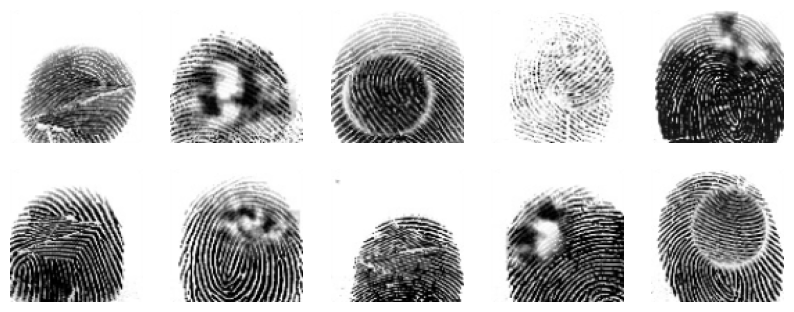

In [28]:
# show the first 10 images in the training dataset
from IPython.display import clear_output

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        #TODO update labels
        #plt.title(int[labels[i]])
        plt.axis("off")
        
clear_output()

# Apply augmentation
When you don't have a large image dataset or when your images are all set in a single direction like ours are, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce over-fitting.

Learn more https://www.tensorflow.org/tutorials/images/data_augmentation

In [31]:
data_augmentation = tf.keras.Sequential([

  # randomly rotates images during training
  tf.keras.layers.RandomRotation(
    # a float represented as fraction of 2 Pi, or a tuple of size 2 representing lower and upper bound for rotating clockwise and counter-clockwise. 
    0.2,                     # A positive values means rotating counter clock-wise, while a negative value means clock-wise. 
    fill_mode='constant',    # Points outside the boundaries of the input are filled according to the given mode (one of {"constant", "reflect", "wrap", "nearest"}).
    interpolation='nearest', # Supported values: "nearest", "bilinear".
    seed=None,               # Integer. Used to create a random seed.
    fill_value=0.0           # the value to be filled outside the boundaries when fill_mode="constant".
),
])

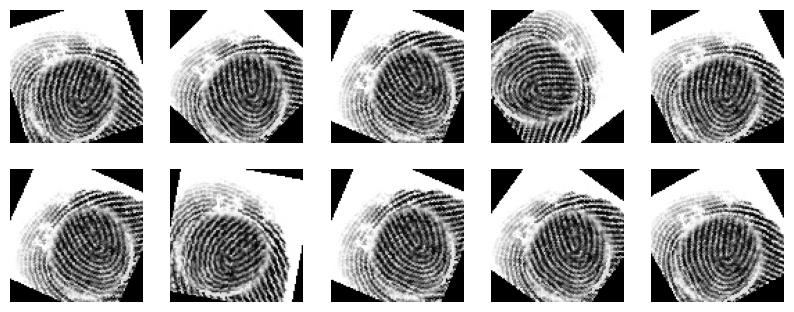

In [32]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[2]
  for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 1, cmap='gray')
    plt.axis('off')
    
clear_output()

## Configure the datasets for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

1. `Caching` a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.
1. `Prefetching` overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
train_directory = scratch_path + "/tf_record_dataset/train"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Save the train_ds dataset to a directory
save_dir = train_directory

tf.data.Dataset.save(train_ds, save_dir)

validation_directory = scratch_path + "/tf_record_dataset/validation"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Save the train_ds dataset to a directory
save_dir = validation_directory

tf.data.Dataset.save(validation_ds, save_dir)

test_directory = scratch_path + "/tf_record_dataset/test"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Save the train_ds dataset to a directory
save_dir = test_directory

tf.data.Dataset.save(test_ds, save_dir)